In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import metrics

In [2]:
ld = pd.read_csv('data/lendingclub_2015-2018.csv')
ld.head()
tmp = ld.tail()
display(tmp)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (20,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,duration
249990,249991,145635719,NaN,35000.0,35000.0,35000.0,60 months,18.94,906.77,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249991,249992,145635974,NaN,7500.0,7500.0,7500.0,36 months,10.72,244.55,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249992,249993,145637006,NaN,30000.0,30000.0,30000.0,60 months,27.27,920.91,E,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249993,249994,145641258,NaN,22650.0,22650.0,22650.0,36 months,10.72,738.54,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249994,249995,145642272,NaN,1000.0,1000.0,1000.0,36 months,18.94,36.63,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36


<AxesSubplot:>

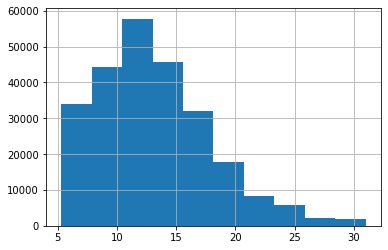

In [3]:
ld['int_rate'].hist()

In [4]:
# view unique values
ld['term'].unique()

# split rows into parts
term_split = ld['term'].str.split(' ')

# view first five rows
print(term_split[:5])

0    [, 36, months]
1    [, 36, months]
2    [, 36, months]
3    [, 36, months]
4    [, 36, months]
Name: term, dtype: object


In [5]:
# the str function can retrieve a specific list element for all rows
term_split.str[1]
ld['duration'] = term_split.str[1]

# add this to the dataframe
display(ld['duration'].head())
# this column is not in integer format. Must fix!

0    36
1    36
2    36
3    36
4    36
Name: duration, dtype: object

In [6]:
# convert column to integer
ld['duration'] = ld['duration'].apply(int)
display(ld['duration'].head())

0    36
1    36
2    36
3    36
4    36
Name: duration, dtype: int64

In [7]:
ld['log_loan_amnt'] = np.log(ld['loan_amnt'])
ld['log_annual_inc'] = np.log(ld['annual_inc']+1)

In [8]:
cols = ['int_rate', 'log_loan_amnt', 'installment', 'log_annual_inc', 'duration', 'fico_range_low', 'revol_util', 'dti']
corr = ld[cols].corr()
corr.style.background_gradient(cmap='coolwarm')

# ld[cols].corr() # <--- use this if you just want the table in non-graphical format

,int_rate,log_loan_amnt,installment,log_annual_inc,duration,fico_range_low,revol_util,dti
int_rate,1.000000,0.083863,0.123667,-0.109038,0.373178,-0.415338,0.262690,0.119422
log_loan_amnt,0.083863,1.000000,0.877808,0.379664,0.413820,0.087016,0.108325,0.045102
installment,0.123667,0.877808,1.000000,0.385775,0.142060,0.053882,0.122495,0.042640
log_annual_inc,-0.109038,0.379664,0.385775,1.000000,0.100023,0.062736,0.068547,-0.240150
duration,0.373178,0.413820,0.142060,0.100023,1.000000,0.009706,0.068505,0.057225
fico_range_low,-0.415338,0.087016,0.053882,0.062736,0.009706,1.000000,-0.476191,-0.025385
revol_util,0.262690,0.108325,0.122495,0.068547,0.068505,-0.476191,1.000000,0.112625
dti,0.119422,0.045102,0.042640,-0.240150,0.057225,-0.025385,0.112625,1.000000


In [9]:
pred_vars = ['log_loan_amnt', 'log_annual_inc', 'fico_range_low', 'revol_util', 'dti', 'duration']

In [10]:
print("before dropping rows with missing data", len(ld))
ld = ld.dropna(subset=pred_vars)
print("after dropping rows with missing data", len(ld))

before dropping rows with missing data 249995
after dropping rows with missing data 249582


In [11]:
from sklearn.model_selection import train_test_split

# use index-based sampling since we have time series data
train, test = train_test_split(ld, test_size=0.25, shuffle=False)

In [12]:
# earliest and latest dates in train
print("training data starts\n", train['issue_d'].head())
print("training data ends\n", train['issue_d'].tail())
# earliest and latest in test
print("testing data starts\n", test['issue_d'].head())
print("testing data ends\n", test['issue_d'].tail())

training data starts
 0    Jul-2007
1    Jul-2007
2    Jul-2007
3    Jul-2007
4    Jul-2007
Name: issue_d, dtype: object
training data ends
 187369    Nov-2017
187370    Nov-2017
187371    Nov-2017
187372    Nov-2017
187373    Nov-2017
Name: issue_d, dtype: object
testing data starts
 187374    Nov-2017
187375    Nov-2017
187376    Nov-2017
187377    Nov-2017
187378    Nov-2017
Name: issue_d, dtype: object
testing data ends
 249990    Dec-2018
249991    Dec-2018
249992    Dec-2018
249993    Dec-2018
249994    Dec-2018
Name: issue_d, dtype: object


In [13]:
reg_fico = sm.OLS(train['int_rate'], train['fico_range_low']).fit()
reg_fico.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                          1.287e+06
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                        0.00
Time:                        16:59:49   Log-Likelihood:                     -5.6714e+05
No. Observations:              187186   AIC:                                  1.134e+06
Df Residuals:                  187185   BIC:                                  1.134e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
fico_range_low     0.0188   1.66e-05   1134.408      0.000       0.019       0.019
==============================================================================
Omnibus:                    10997.634   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13259.038
Skew:                           0.605   Prob(JB):                         0.00
Kurtosis:                       3.483   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
reg_multi = sm.OLS(train['int_rate'], train[pred_vars], hasconst=False).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   0.910
Model:                            OLS   Adj. R-squared (uncentered):              0.909
Method:                 Least Squares   F-statistic:                          3.135e+05
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                        0.00
Time:                        16:59:51   Log-Likelihood:                     -5.3544e+05
No. Observations:              187186   AIC:                                  1.071e+06
Df Residuals:                  187180   BIC:                                  1.071e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
log_loan_amnt      0.4867      0.018     27.573      0.000       0.452       0.521
log_annual_inc     0.4736      0.019     25.196      0.000       0.437       0.510
fico_range_low    -0.0094      0.000    -38.372      0.000      -0.010      -0.009
revol_util         0.0350      0.000     79.704      0.000       0.034       0.036
dti                0.0454      0.001     52.977      0.000       0.044       0.047
duration           0.1685      0.001    169.180      0.000       0.167       0.170
==============================================================================
Omnibus:                    20040.090   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33725.942
Skew:                           0.755   Prob(JB):                         0.00
Kurtosis:                       4.429   Cond. No.                     1.62e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
print(reg_fico.aic)
print(reg_multi.aic)

1134288.3080747342
1070889.1563837891


In [16]:
sm.stats.anova_lm(reg_fico, reg_multi)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,187185.0,4.693344e+06,0.0,NaN,NaN,NaN
1,187180.0,3.344763e+06,5.0,1.348581e+06,15093.884858,0.0


In [17]:
fico_pred = reg_fico.predict(test['fico_range_low'])

fico_rmse = metrics.mean_squared_error(test['int_rate'], fico_pred, squared=False)
print("RMSE:", fico_rmse)

RMSE: 5.4935559541762


In [18]:
multi_pred = reg_multi.predict(test[pred_vars])

multi_rmse = metrics.mean_squared_error(test['int_rate'], multi_pred, squared=False)
print("RMSE:", multi_rmse)

RMSE: 4.706613506113946


# Tasks

1. Can you build a model that performs significantly better than the models already built? Train the model and compare it. Which variables did you use and why do you think they improved the model?

2. What level of RMSE would you consider acceptable would you consider appropriate in this situation?


## Task 1

Can you build a model that performs significantly better than the models already built? Train the model and compare it. Which variables did you use and why do you think they improved the model?

In [51]:
ld = pd.read_csv('data/lendingclub_2015-2018.csv')
ld.head()
tmp = ld.tail()
display(tmp)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (20,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,duration
249990,249991,145635719,NaN,35000.0,35000.0,35000.0,60 months,18.94,906.77,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249991,249992,145635974,NaN,7500.0,7500.0,7500.0,36 months,10.72,244.55,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249992,249993,145637006,NaN,30000.0,30000.0,30000.0,60 months,27.27,920.91,E,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,60
249993,249994,145641258,NaN,22650.0,22650.0,22650.0,36 months,10.72,738.54,B,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36
249994,249995,145642272,NaN,1000.0,1000.0,1000.0,36 months,18.94,36.63,D,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,36


In [52]:
# view unique values
ld['term'].unique()

# split rows into parts
term_split = ld['term'].str.split(' ')

# view first five rows
print(term_split[:5])

0    [, 36, months]
1    [, 36, months]
2    [, 36, months]
3    [, 36, months]
4    [, 36, months]
Name: term, dtype: object


In [53]:
# the str function can retrieve a specific list element for all rows
term_split.str[1]
ld['duration'] = term_split.str[1].apply(int)

# add this to the dataframe
display(ld['duration'].head())


0    36
1    36
2    36
3    36
4    36
Name: duration, dtype: int64

In [54]:
ld['log_funded_amnt'] = np.log(ld['funded_amnt'])
ld['log_last_pymnt_amnt'] = np.log(ld['last_pymnt_amnt']+1)

In [55]:
pred_vars = ['log_funded_amnt', 'inq_last_6mths', 'open_acc', 'bc_util', 'log_last_pymnt_amnt' 
             ,'duration']

In [56]:
print("before dropping rows with missing data", len(ld))
ld = ld.dropna(subset=pred_vars)
print("after dropping rows with missing data", len(ld))

before dropping rows with missing data 249995
after dropping rows with missing data 241305


In [57]:
# use index-based sampling since we have time series data
train, test = train_test_split(ld, test_size=0.25, shuffle=False)

In [58]:
reg_multi = sm.OLS(train['int_rate'], train[pred_vars], hasconst=False).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               int_rate   R-squared (uncentered):                   0.915
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                          3.242e+05
Date:                Tue, 19 Oct 2021   Prob (F-statistic):                        0.00
Time:                        17:08:09   Log-Likelihood:                     -5.1239e+05
No. Observations:              180978   AIC:                                  1.025e+06
Df Residuals:                  180972   BIC:                                  1.025e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
log_funded_amnt         0.2840      0.007     39.156      0.000       0.270       0.298
inq_last_6mths          1.2735      0.011    117.876      0.000       1.252       1.295
open_acc               -0.0311      0.002    -17.298      0.000      -0.035      -0.028
bc_util                 0.0438      0.000    125.490      0.000       0.043       0.044
log_last_pymnt_amnt     0.0117      0.006      2.020      0.043       0.000       0.023
duration                0.1726      0.001    177.848      0.000       0.171       0.174
==============================================================================
Omnibus:                    21085.333   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32356.254
Skew:                           0.852   Prob(JB):                         0.00
Kurtosis:                       4.178   Cond. No.                         89.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
#print(high_fico.aic)
print(reg_multi.aic)

1024786.7440574181


In [60]:
multi_pred = reg_multi.predict(test[pred_vars])

multi_rmse = metrics.mean_squared_error(test['int_rate'], multi_pred, squared=False)
print("RMSE:", multi_rmse)

RMSE: 4.578078326741005


My OLS Regression model is improved from out lab example. Using log_funded_amnt, inq_last_6mths, open_acc, bc_util, log_last_pymnt_amnt, and duration I acheved and adjusted R^2 of 0.915 compared to 0.909 in class. My model's AIC and RMSE were 1024786.74 and 4.5781 respectively. While the model we did in calss the AIC and RMSE were 1070889.16 and 4.7066 respectively. My model had lower AIC and RMSE showing that it is better fitted than the model we did in class.

# Task 2

What level of RMSE would you consider acceptable would you consider appropriate in this situation?

I don't believe there is a standard acceptable level of of RMSE. In this case we are looking at interest rates on loans and trying to predict them. RMSE is the standard deviation the actual interest rate is away from predicted interest rate. In my models case on average I was 4.5781 standard deviations away from the actual interest rate. Since interest rates of loans is so important and could impact a persons finacial future I would be more comfortable with an RMSE under 2, meaning on average my predictions were 2less than 2 standard deviations away from the actual. 